In [3]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Custom library for Censored GP
"""GPyv1 is a forked and modified version of the GPy package in order to deal with censoring. 
For this reason, below we import the custom GPt (where the 't' stands for Tobit) and the standard
GPy."""
from GPyv1 import GPy as GPt 
import GPy

In [ ]:
"""In order to use custom optimizers for the training of Censored Models it is important to have 
installed the 'climin' package for optimization: this should fix it.

I am having some problems in running it on windows, however, on AIMonster it runs without issues."""
try:
    import climin
except:
    !pip install climin
    import climin

In [4]:
plt.style.use("ggplot")

As a working example let's use both libraries on the same toy problem so to explore the training scheme for both models: 

### Toy data construction 

_Let's define the experimental design for an effective observation/understanding of the censoring issue:_

1. _Given the underlying function $\frac{1}{2} \sin(2x) + 1$ we sample 100 equally spaced observations between $x=0$ and $x=10$ (for simplicity and without loss of generality we assume to have absence of observation noise)._

2. _Generate censored versions of the observations defined in 1. The censoring will be characterized by (i) Number of censored points out of the 100 samples (ii) Censoring intensity_

3. _Fit both Gaussian and Censored GP to the data and observe model fit + record performances_

In [5]:
"""Data is generated as follows:
- Define latent function y(x) = 0.5*sin(2x) + 2
- Generetae observations from the latent function y_obs (assuming some small observation noise, let's focus on censoring)
- Randomly pick a certain percentage of these points for censoring (censoring = ...)
- Apply a p% manual censoring to those points.
"""

np.random.seed(10)
# Define underlying function
x = np.linspace(0, 10, 100)
y_true = 0.5*np.sin(2*x) + 2

# Generate noisy observations
y_obs = y_true + np.random.normal(loc=0, scale=0.05, size=x.shape[0])
y_cens = copy.deepcopy(y_obs)

# Select random points as censored and apply p% censoring
censoring = np.random.binomial(n=1, p=0.4, size=x.shape[0])
p = 0.6
y_cens[censoring == 1] = y_obs[censoring == 1]*(1-p)

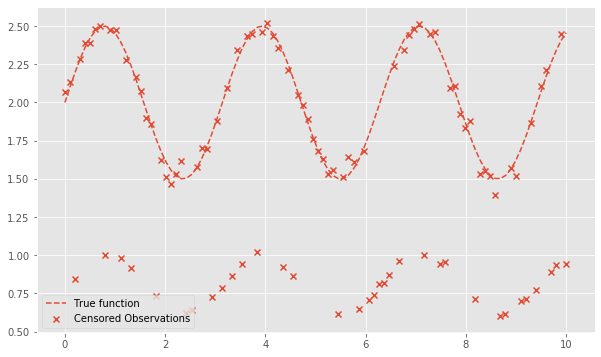

In [6]:
# Let's visualize the data
plt.figure(figsize=(10,6))
plt.plot(x, y_true, linestyle="--", label="True function")
plt.scatter(x, y_cens, marker="x", label="Censored Observations")
plt.legend()
plt.show()

## Models

The training scheme can be summarized as follows:
1. Define the kernel
2. Build the model
3. Optimize
4. Generate predictions

For simplicity we will assume to use an RBF Kernel for both Censored and Non-Censored GPs

**1) Gaussian GP**

In [7]:
"""Define kernel"""
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [8]:
"""Build model.

GPRegression assumes Gaussian Likelihood (no censoring here).
"""
gp = GPy.models.GPRegression(X=x.reshape(-1,1), Y=y_cens.reshape(-1,1), kernel=kernel, noise_var=0.1)

In [9]:
"""Optimize

For the case of Gaussian Likelihood we will use BFGS as an optimization algorithm <- quicker convergence in this 'easier' problem definition.

The optimization regards the kernel hyper-parameters as well as the likelihood noise.
"""
gp.optimize(optimizer="BFGS", max_iters=5000, messages=True)

In [10]:
"""Predict

gp.predict outputs mean and variance of the exact posterior distribution which we use for our predictions + confidence intervals."""
y_pred, var = gp.predict(x.reshape(-1,1))
y_pred = y_pred.reshape(-1,)
std = np.sqrt(var.reshape(-1,))

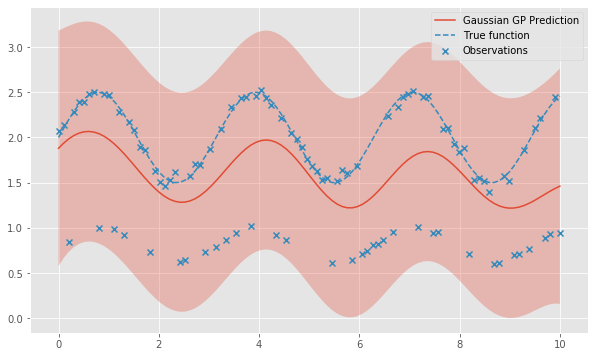

In [11]:
plt.figure(figsize=(10,6))
plt.plot(x, y_pred, label="Gaussian GP Prediction")
plt.fill_between(x, y_pred - 2*std, y_pred + 2*std, alpha=0.3)
plt.plot(x, y_true, label="True function", linestyle="--")
plt.scatter(x, y_cens, marker="x", label="Observations")
plt.legend()
plt.show()

**2) CensoredGP**

The training scheme is very similar to the Gaussian GP case, however there are some details worth underlying.

1. The GPCensoredRegression model requires two additional arguments compared to the GPRegression showed above:
    - censoring: a binary vector indicating which observations in the input data are to be considered as censored
    - likelihood: since we are moving away from a Gaussian likelihood setting we need to use the custom 'Tobit Likelihood' (which also requires the 'censoring' vector)

In [12]:
"""Define kernel"""
kernel = GPt.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [13]:
"""Build model"""
censgp = GPt.models.GPCensoredRegression(X=x.reshape(-1,1), Y=y_cens.reshape(-1,1), censoring=censoring, 
                                         kernel=kernel, likelihood=GPt.likelihoods.Tobit(censoring=censoring, variance=0.1))

 C:\Users\daga\Desktop\Material\Donkey Material\TRC\GPyv1\GPy\likelihoods\likelihood.py:299: FutureWarning:arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [23]:
"""Optimize

(Probably there is a dependency on climin in order to use the adam optimizer here)"""
censgp.optimize(optimizer="adam", max_iters=5000, messages=True)

In [28]:
"""Predict

Since we do not have an analytical expression for the posterior (as we had in the Gaussian GP case) 
we have to manually generate samples from the posterior (approximated with EP inference).
We the take the mean and 90% confidence interval of the posterior samples."""
# Define predictive distribution (and relative CI) by averaging out the prediction given by the posterior samples of the latent variable f
x_new = copy.deepcopy(x) # define test points (in this case we want to see training set predictions) 

n_samples = 3000
y_pred_cens_samples = censgp.posterior_samples_f(x_new.reshape(-1,1), size=n_samples).reshape(-1,n_samples)
y_pred_cens = y_pred_cens_samples.mean(axis=1)
y_05_cens = np.quantile(a=y_pred_cens_samples, q=0.05, axis=1)
y_95_cens = np.quantile(a=y_pred_cens_samples, q=0.95, axis=1)

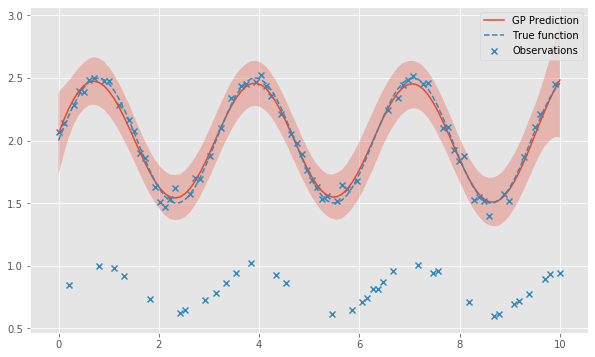

In [29]:
plt.figure(figsize=(10,6))
plt.plot(x_new, y_pred_cens, label="GP Prediction")
plt.fill_between(x_new, y_05_cens, y_95_cens, alpha=0.3)
plt.plot(x, y_true, label="True function", linestyle="--")
plt.scatter(x, y_cens, marker="x", label="Observations")
plt.legend()
plt.show()